# Proyecto 3: Procesamiento del Lenguaje Natural

Por Vanesa Flores. Link en [GitHub](https://github.com/vanesa0894/Procesamiento_del_Lenguaje_Natural_NLP_Proyecto3).

## Objetivo:

Implementar un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. Siendo 1 estrella la puntuación más baja y 5 estrellas la más alta.

### Dataset: The Multilingual Amazon Reviews Corpus

Se puede encontrar el dataset [aquí](https://github.com/kang205/SASRec) y su [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt).

El conjunto de datos contiene comentarios en español, recopiladas entre el 1 de noviembre de 2015 y el 1 de noviembre de 2019. Y además, presenta las siguientes características:

- `review_id`: ID del comentario.
- `product_id`: ID del producto.
- `reviewer_id`: ID de un revisor.
- `stars`: número de estrellas asignadas al comentario.
- `review_body`: texto del comentario.
- `review_title`: título del comentario.
- `language`: idioma del comentario.
- `product_category`: categoría general del producto.

### Librerías Útiles

In [1]:
import itertools
import unidecode

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import re

import nltk
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')

import stanza
stanza.download("es")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Optimizar recursos
import gc

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vanes\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vanes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2021-07-21 14:00:31 INFO: Downloading default packages for language: es (Spanish)...
2021-07-21 14:00:32 INFO: File exists: C:\Users\vanes\stanza_resources\es\default.zip.
2021-07-21 14:00:38 INFO: Finished downloading models and saved to C:\Users\vanes\stanza_resources.


# Carga de datos

Contámos con 3 archivos en formato JSON con datos estructurados. Uno para entrenamiento (train), uno para testeo (test) y uno de desarrollo (dev). 

In [2]:
#Conjunto de entrenamiento
train = pd.read_json('dataset_es_train.json', lines=True)
train.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


In [3]:
#Conjunto de testeo
test = pd.read_json('dataset_es_test.json', lines=True)
test.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0038754,product_es_0113523,reviewer_es_0580071,1,no me llego el articulo me lo mando por correo...,no me llego,es,wireless
1,es_0748979,product_es_0017036,reviewer_es_0819733,1,"la mensajería horrible, no compro mas",amazon sigue sin cumplir en las entregas,es,home
2,es_0411746,product_es_0138642,reviewer_es_0508607,1,Estoy muy decepcionado con el vendedor ya que ...,ESTAFA EN EL ENVÍO,es,toy
3,es_0786686,product_es_0170887,reviewer_es_0491157,1,Mi valoración no es sobre el producto sino sob...,Estafa de Amazon,es,home
4,es_0429700,product_es_0710642,reviewer_es_0008745,1,Pues tenía interés en este libro y probé la ve...,No conseguí pasar de la portada en Kindle,es,digital_ebook_purchase


In [4]:
#Conjunto de desarrollo
dev = pd.read_json('dataset_es_dev.json', lines=True)
dev.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


# Análisis Exploratorio de Datos

En lo que sigue, vamos a explorar algunas características de nuestros datos:

In [5]:
#Tamaño de los datasets:
print('Dimensión del dataset de entrenamiento:' , train.shape)
print('Dimensión del dataset de testeo:       ' , test.shape)
print('Dimensión del dataset de desarrollo:   ' , dev.shape)

Dimensión del dataset de entrenamiento: (200000, 8)
Dimensión del dataset de testeo:        (5000, 8)
Dimensión del dataset de desarrollo:    (5000, 8)


Se observa que el dataset de entrenamiento es 40 veces más grande que los datasets de testeo y desarrollo; representando así el 95.23% del total de los datos. También se evidencia que todos tienen las misma cantidad de columnas y que además, representan las mismas características; incluyendo la variable a predecir `stars`. 

Partiendo de lo antes comentado, seguiremos con el análisis exploratorio y el preprocesamiento de los datos con un único dataset que contenga la unión de los 3 datasets dados. 

In [6]:
data=pd.concat([train,test,dev], sort=False).reset_index(drop=True)
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


In [7]:
data.tail()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
209995,es_0179515,product_es_0158275,reviewer_es_0273644,5,Me ha encantado la cesta. Ha llegado impecable...,guadalupe,es,home
209996,es_0894902,product_es_0953259,reviewer_es_0153773,5,Desempeña su función correctamente,calidad precio,es,camera
209997,es_0760496,product_es_0731995,reviewer_es_0171091,5,Me ha encantado la diadema! Las flores son tal...,Excelente,es,toy
209998,es_0178380,product_es_0402051,reviewer_es_0686937,5,"A mi me gustan mucho las fundas TPU, ya que so...",Genial,es,wireless
209999,es_0810087,product_es_0684221,reviewer_es_0613091,5,El artículo ha cumplido con las expectativas q...,Buena calidad,es,apparel


In [8]:
#Información general de los datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210000 entries, 0 to 209999
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   review_id         210000 non-null  object
 1   product_id        210000 non-null  object
 2   reviewer_id       210000 non-null  object
 3   stars             210000 non-null  int64 
 4   review_body       210000 non-null  object
 5   review_title      210000 non-null  object
 6   language          210000 non-null  object
 7   product_category  210000 non-null  object
dtypes: int64(1), object(7)
memory usage: 12.8+ MB


In [9]:
#Valores Faltantes
data.isna().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

In [10]:
#Cuántos valores únicos hay por columna
print('Cantidad de clases/estrellas:           ', len(data.stars.unique()))
print('Cantidad de categorías de producto:     ', len(data.product_category.unique()))
print('Cantidad de idiomas en los comentarios: ', len(data.language.unique()))
print('% de id de comentarios únicos:          ', len(data.review_id.unique())*100/len(data.review_id.unique()))
print('% de productos únicos:                  ', len(data.product_id.unique())*100/len(data.review_id.unique()))
print('% de usuarios únicos:                   ', len(data.reviewer_id.unique())*100/len(data.review_id.unique()))
print('% de comentarios únicos:                ', len(data.review_body.unique())*100/len(data.review_id.unique()))
print('% de título de comentarios únicos:      ', len(data.review_title.unique())*100/len(data.review_id.unique()))

Cantidad de clases/estrellas:            5
Cantidad de categorías de producto:      30
Cantidad de idiomas en los comentarios:  1
% de id de comentarios únicos:           100.0
% de productos únicos:                   74.50380952380952
% de usuarios únicos:                    89.11428571428571
% de comentarios únicos:                 99.10809523809523
% de título de comentarios únicos:       55.78857142857143


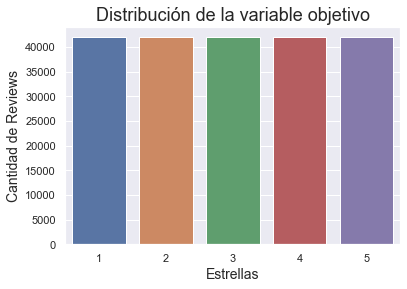

In [11]:
#Cómo están distribuidas las clases (estrellas)
sns.countplot(data=data, x=data.stars)
plt.title('Distribución de la variable objetivo', fontsize=18)
plt.xlabel('Estrellas', fontsize=14)
plt.ylabel('Cantidad de Reviews', fontsize=14)
plt.show()

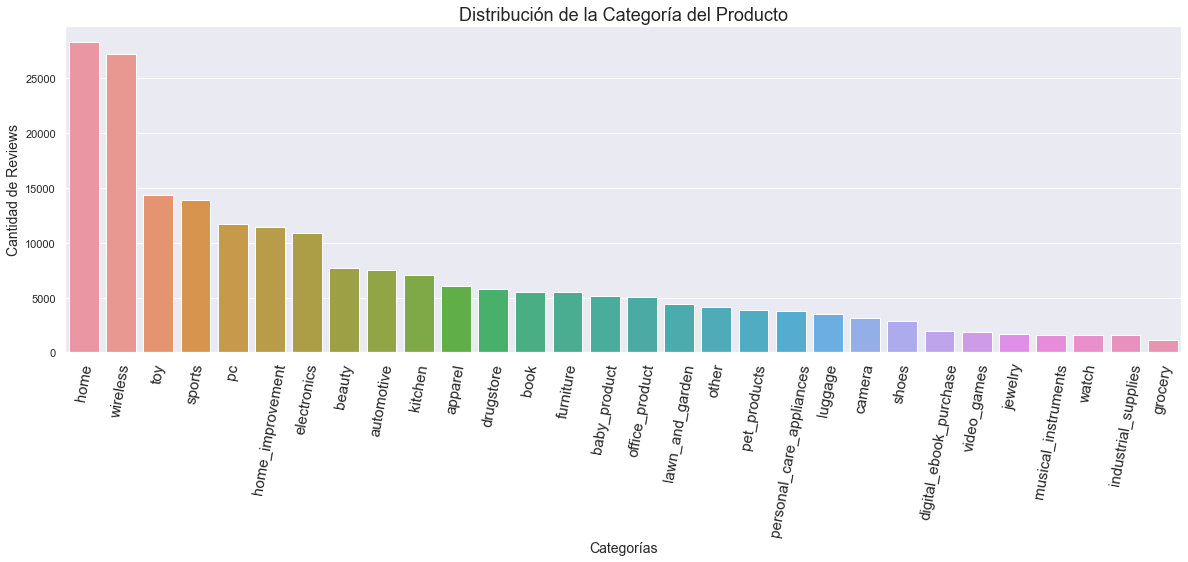

In [12]:
#Distribución de la variable producto_category
plt.subplots(figsize=(20,6))
sns.countplot(data=data, x=data.product_category, order = data.product_category.value_counts().index)
plt.title('Distribución de la Categoría del Producto', fontsize=18)
plt.xlabel('Categorías', fontsize=14)
plt.ylabel('Cantidad de Reviews', fontsize=14)
plt.xticks(rotation=80, fontsize=15)
plt.show()

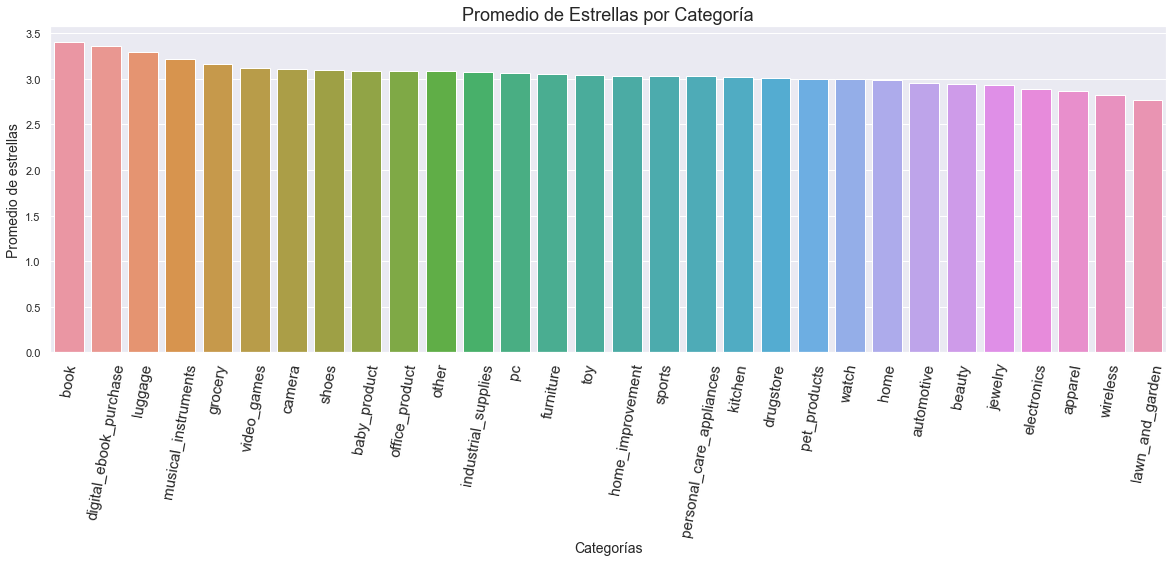

In [13]:
#Promedio de estrellas por categoría 
data_avg = data.stars.groupby([data['product_category']]).mean().reset_index(name='stars_avg')
data_avg = data_avg.sort_values(by='stars_avg', ascending=False).reset_index()
data_avg = data_avg.drop(columns=['index'])

plt.subplots(figsize=(20,6))
sns.barplot(data=data, x=data_avg.product_category, y=data_avg.stars_avg)
plt.title('Promedio de Estrellas por Categoría', fontsize=18)
plt.xlabel('Categorías', fontsize=14)
plt.ylabel('Promedio de estrellas', fontsize=14)
plt.xticks(rotation=80, fontsize=15)
plt.show()

In [14]:
#Algunos comentarios y su calificación
for i in range(0,5):
    index_random = np.random.randint(0,4999)
    review_body = data.review_body.iloc[index_random,]
    stars=data.stars.iloc[index_random,]
    print(index_random, review_body, stars)

2806 Llevo muchos años usando este producto porque me encantaba su olor, se lo añadía a todas mis cremas para que le diera ese olor maravilloso, pero al recibir este producto y olerlo no me ha gustado nada, volveré a comprar la marca que siempre he usado. 1
836 No puedo opinar sobre el artículo porque no lo he recibido.... tuve que reclamar la devolución de mi dinero ... 1
2572 Me ponía fecha de entrega el día 28 de diciembre y todavía no me ha llegado y lo necesitaba para ayer.... 1
4351 Muy descontento, menos las patas, todo es plástico.. y del malo.. primer dia y rotas 1
2433 Tengo un problema con la manta ya compré hace 2 meses y ya no calienta como antes. qué solución podríais darme. gracias 1


In [15]:
#Algunos títulos de comentarios y su calificación
for i in range(0,5):
    index_random = np.random.randint(0,4999)
    review_title = data.review_title.iloc[index_random,]
    stars=data.stars.iloc[index_random,]
    print(index_random, review_title, stars)

4692 Mantiene poco tiempo la te 1
2181 No repetiría 1
4340 Mala experiencia. 1
4300 Tapa altavoz 1
3848 Estafa 1


### Observaciones:

* El único dato numérico del dataset es la cantidad de estrellas `stars`.
* No hay presencia de datos faltantes.
* Existen 5 clases distribuidas de forma balanceada en el dataset y representan la cantidad de estrellas asignadas al producto.
* Las categorías mejor puntuadas son las de 'book','digital_ebook_purchase' y 'luggage'. 
* Hay 30 categorías de productos, donde las más comentadas son 'home', 'wireless' y 'toy'.
* La cantidad de usuarios y productos únicos representan el 89.11% y 74.50% del total de comentarios, respectivamente.
* El 99.10% de los comentarios y el 55.78% de los títulos de comentarios son distintos en todo el corpus.
* Las variables `review_body` y `review_title` contienen información importante para el desarrollo del modelo. 

# Preprocesamiento de los datos

Basándonos en las observaciones mencionadas anteriormente se decide condensar la información más relevante uniendo las columnas `review_body` y `review_title`. Además se decide eliminar algunas columnas que en principio se consideran poco importantes para el modelo.

In [16]:
data['total_review']=data.review_body + ' ' + data.review_title
dataset=data.drop(columns=['review_id','product_id', 'reviewer_id','review_body','review_title','language','product_category'])
dataset.head()

,stars,total_review
0,1,Nada bueno se me fue ka pantalla en menos de 8...
1,1,"Horrible, nos tuvimos que comprar otro porque ..."
2,1,Te obligan a comprar dos unidades y te llega s...
3,1,"No entro en descalificar al vendedor, solo pue..."
4,1,Llega tarde y co la talla equivocada Devuelto


## Normalización

Procedemos a realizar algunas transformaciones a los comentarios con el fin de normalizarlos y eliminar posible ruido que afecte el desempeño de los futuros modelos a entrenar. Para empezar, como sabemos python es sensible a mayúsculas y minúsculas, por que palabras como 'la', 'La' ó 'LA' las tomaría como elementos diferentes en nuestro corpus. Es por ello que pasaremos todas las palabras del dataset a minúsculas.  

In [17]:
# Pasamos todas la palabras a minúsculas
dataset['total_review'] = dataset['total_review'].str.lower()

Definiremos algunas palabras denominadas stopwords, que suelen repetirse con mucha frecuencia en el corpus y no aportan valor al modelo. Así, posteriormente podemos eliminarlas de los comentarios. Para esto utilizaremos la librería NLTK que provee un conjunto de stopwords en español. 

A la lista de stopwords establecidas por la librería le añadiremos algunas que consideramos importantes como por ejemplo algunas palabras sin acentos o meses del año y, sacaremos otras palabras como por ejemplo 'no' que, unida con otras pueden agregar información importante.

In [18]:
stopwords = nltk.corpus.stopwords.words('spanish')
#Considermos incluir al listado de stopwords de nltk algunas palabras sin su acento.
stopwords_sin_acentos =  ['si', 'tambien', 'que', 'el', 'mio', 'mia', 'mios', 'mias', 'estas', 'esta', 'estamos', 'estais', 'estan', 'esta', 'estes', 
                         'esteis', 'esten', 'estare', 'estaras', 'estara', 'estareis', 'estaran', 'estaria', 'estarias', 'estariamos', 'estariais', 
                         'estarian', 'estuvieramos', 'estuviesemos', 'habeis',  'hayais','habre', 'habras', 'habra', 'habreis', 'habran',
                         'habria', 'habrias', 'habriamos', 'habriais', 'habrian', 'habia', 'habias', 'habiamos', 'habiais', 'habian', 'hubieramos', 
                         'hubiesemos', 'seais', 'sere', 'seras', 'sera', 'sereis', 'seran', 'seria', 'serias', 'seriamos', 'seriais', 'serian', 
                         'eramos', 'fueramos','fuesemos', 'teneis', 'tengais', 'tendre', 'tendras', 'tendra', 'tendreis', 'tendran', 'tendria', 'tendrias',
                         'tendriamos', 'tendriais', 'tendrian', 'tenia', 'tenias', 'teniamos', 'teniais', 'tenian', 'tuvieramos', 'tuviesemos']

#Consideremos incluir algunas palabras cuya función no aporta al modelo
stopwords_extra = ['vez', 'ademas','dia','dias','mes','meses','año','ano','lunes','martes','miercoles','jueves','viernes','sabado','domingo','ayer','hoy','mañana','manana',
                   'enero','febrero','marzo','abril','mayo','junio','julio','agosto','septiembre','octubre','noviembre','diciembre','amazon', 'primero', 'segundo',
                   'tercero','cuarto','quinto', 'sexto','septimo','octavo','noveno','decimo','uno','dos','tres','cuatro','cinco','seis','siete','ocho','nueve','diez',
                   'cien','mil']
#Consideremos excluir de las stopwords algunos adverbios de cantidad /afirmación/negación
adv_cantidad = ['muy','mucho','muchos','mas','poco','nada','sin','tanto','ni','no','si']

#Definimos nuevas stopwords
stopwords = stopwords + stopwords_sin_acentos + stopwords_extra
stopwords = [word for word in stopwords if word not in adv_cantidad]
#stopwords

Para continuar con el proceso de normalización de los datos vamos a definir las siguientes 3 funciones:

`normalizar`: esta función permitirá remover del corpus todos los elementos que se consideran pueden generan ruido en nuestro modelo y que además, sabemos no aportaran información útil al modelo basándonos en la naturaleza del problema. Entre ellos están:
* Eliminar acentos.
* Eliminar signos de puntuación.
* Eliminar números.
* Eliminar palabras de menos de 2 letras.
* Eliminar stopwords.
* Tokenizar el corpus.

Para este último paso, se utilizá el módulo `tokenize` de la librería NLTK que nos permite dividir cada instancia del corpus en unidades de texto, en este caso se usa la función `word_tokenize` que nos devuelve una copia del texto divido en tokens=palabras.


In [19]:
def normalizar(reviews, stopwords, list_tokens):
    for i in range(len(reviews)):
        review = reviews[i] #selecciono el comentario
        #Elimino acentos
        review = unidecode.unidecode(str(review)) 
        #Elimino todo lo que no sea letras
        review = re.sub("[^a-zA-Z]"," ",review)
        #Elimino números
        review = re.sub("[0-9]"," ",review)   
        #Tokenizo
        review = nltk.word_tokenize(review)
        #Remuevo StopWords
        review = [palabra for palabra in review if  not palabra in stopwords] 
        #Elimino palabras con menos de 2 letras.
        review = [palabra for palabra in review if len(palabra)>2]
        # Agrego el resultado a la lista
        list_tokens.append(review) 

In [20]:
# Normalizo e incluyo al dataset una columna con los tokens generados
reviews=dataset.total_review.tolist()
reviews_tokens=[]
normalizar(reviews, stopwords, reviews_tokens)
dataset['review_tokens']=reviews_tokens
dataset.iloc[:10]

,stars,total_review,review_tokens
0,1,nada bueno se me fue ka pantalla en menos de 8...,"[nada, bueno, pantalla, menos, recibido, respu..."
1,1,"horrible, nos tuvimos que comprar otro porque ...","[horrible, comprar, sabemos, ingles, informati..."
2,1,te obligan a comprar dos unidades y te llega s...,"[obligan, comprar, unidades, llega, solo, form..."
3,1,"no entro en descalificar al vendedor, solo pue...","[entro, descalificar, vendedor, solo, puedo, d..."
4,1,llega tarde y co la talla equivocada devuelto,"[llega, tarde, talla, equivocada, devuelto]"
5,1,jamás me llegó y el vendedor nunca contacto co...,"[jamas, llego, vendedor, nunca, contacto, conm..."
6,1,"el paraguas es de muy mala calidad,da la sensa...","[paraguas, muy, mala, calidad, sensacion, romp..."
7,1,tuve que devolverla porque al ser triangular n...,"[devolverla, ser, triangular, agarra, forma, c..."
8,1,estoy esperando despues de protestar varias ve...,"[esperando, despues, protestar, varias, veces,..."
9,1,"defectuoso. en apariencia muy bien producto, p...","[defectuoso, apariencia, muy, bien, producto, ..."


`stemming`: utilizaremos esta función con el fin de llevar cada palabra del corpus a su palabra raíz. Este proceso se realiza eliminando los sufijos o terminaciones de las palabras basándose en el  [Algoritmo Snowball en español](http://snowball.tartarus.org/algorithms/spanish/stemmer.html). La librería NLTK provee la clase `SnowballStemmer` que funciona bastante bien para encontrar el stem de cada palabra en español.

In [21]:
def stemming(reviews_tokens, reviews_stemm):
    stemmer = SnowballStemmer('spanish')
    for rev in reviews_tokens:
        rev=[stemmer.stem(palabra) for palabra in rev]
        rev = " ".join(rev)
        reviews_stemm.append(rev)

In [22]:
# Stemmatizo e incluyo al dataset una columna con los stems generados
reviews_stemm=[]
stemming(reviews_tokens,reviews_stemm)
dataset['reviews_stemm'] = reviews_stemm
dataset.iloc[:10]

,stars,total_review,review_tokens,reviews_stemm
0,1,nada bueno se me fue ka pantalla en menos de 8...,"[nada, bueno, pantalla, menos, recibido, respu...",nad buen pantall men recib respuest fabric tel...
1,1,"horrible, nos tuvimos que comprar otro porque ...","[horrible, comprar, sabemos, ingles, informati...",horribl compr sab ingles informat despu hor ca...
2,1,te obligan a comprar dos unidades y te llega s...,"[obligan, comprar, unidades, llega, solo, form...",oblig compr unidad lleg sol form reclam autent...
3,1,"no entro en descalificar al vendedor, solo pue...","[entro, descalificar, vendedor, solo, puedo, d...",entro descalific vendedor sol pued dec tras es...
4,1,llega tarde y co la talla equivocada devuelto,"[llega, tarde, talla, equivocada, devuelto]",lleg tard tall equivoc devuelt
5,1,jamás me llegó y el vendedor nunca contacto co...,"[jamas, llego, vendedor, nunca, contacto, conm...",jam lleg vendedor nunc contact conmig pes inte...
6,1,"el paraguas es de muy mala calidad,da la sensa...","[paraguas, muy, mala, calidad, sensacion, romp...",paragu muy mal calid sensacion romp abres muy ...
7,1,tuve que devolverla porque al ser triangular n...,"[devolverla, ser, triangular, agarra, forma, c...",devolv ser triangul agarr form comod escritur ...
8,1,estoy esperando despues de protestar varias ve...,"[esperando, despues, protestar, varias, veces,...",esper despu protest vari vec veo solucion hace...
9,1,"defectuoso. en apariencia muy bien producto, p...","[defectuoso, apariencia, muy, bien, producto, ...",defectu aparient muy bien product terc uso vas...


En este punto, nos encontramos con un dataset limpio para modelar. Sin embargo, existe otro método de normalización de las palabras relacionado con la función que cumple dicha palabra en el texto. Ésto es, si la palabra es un verbo, un adjetivo, un adverbio, etc.

Primero, definamos una función que nos permita unir los tokens con espacios. Esto será útil más adelante.

In [23]:
def unir_palabras(fila):
    lista = fila['review_tokens']
    palabras_unidas = ( " ".join(lista))
    return palabras_unidas

In [24]:
dataset['review_tokens_unidos']= dataset.apply(unir_palabras, axis=1)

Ahora, definamos nuestra tercera función de normalización.

`lemmatizar`: nos permitirá encontrar la raíz de la palabra en función al rol que cumple ésta en el texto. Para esto, en vez de continuar con la librería NLTK, utilizaremos la librería [Stanza](https://stanfordnlp.github.io/stanza/) que contiene lemmatizador en español y es bastante eficiente. 

Es importante resaltar en este punto, que el proceso de lemmatización para los 210.000 comentarios conlleva un tiempo de ejecución prolongado.

In [25]:
# Lemmatizo e incluyo al dataset una columna con los lemmas generados
def lemmatizar(review_tokens_unidos, review_lemma):
    nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma')
    for rev in range(len(review_tokens_unidos)):
        doc=nlp(review_tokens_unidos[rev])
        rev_lemma=[palabra.lemma for oracion in doc.sentences for palabra in oracion.words]
        rev_lemma=" ".join(rev_lemma)
        review_lemma.append(rev_lemma)

In [93]:
review_tokens_unidos=dataset.review_tokens_unidos.tolist()
reviews_lemma=[]
lemmatizar(review_tokens_unidos,reviews_lemma)

2021-07-13 16:55:02 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |

2021-07-13 16:55:02 INFO: Use device: cpu
2021-07-13 16:55:02 INFO: Loading: tokenize
2021-07-13 16:55:02 INFO: Loading: mwt
2021-07-13 16:55:02 INFO: Loading: pos
2021-07-13 16:55:02 INFO: Loading: lemma
2021-07-13 16:55:02 INFO: Done loading processors!


In [94]:
dataset['reviews_lemma'] = reviews_lemma
dataset.iloc[:10]

,stars,total_review,review_tokens,reviews_stemm,review_tokens_unidos,reviews_lemma
0,1,nada bueno se me fue ka pantalla en menos de 8...,"[nada, bueno, pantalla, menos, recibido, respu...",nad buen pantall men recib respuest fabric tel...,nada bueno pantalla menos recibido respuesta f...,nada buen pantalla menos recibido respuesta fa...
1,1,"horrible, nos tuvimos que comprar otro porque ...","[horrible, comprar, sabemos, ingles, informati...",horribl compr sab ingles informat despu hor ca...,horrible comprar sabemos ingles informatico de...,horrible comprar saber ingle informatico despu...
2,1,te obligan a comprar dos unidades y te llega s...,"[obligan, comprar, unidades, llega, solo, form...",oblig compr unidad lleg sol form reclam autent...,obligan comprar unidades llega solo forma recl...,obligar comprar unidad llegar solo forma recla...
3,1,"no entro en descalificar al vendedor, solo pue...","[entro, descalificar, vendedor, solo, puedo, d...",entro descalific vendedor sol pued dec tras es...,entro descalificar vendedor solo puedo decir t...,entrar descalificar vendedor solo poder decir ...
4,1,llega tarde y co la talla equivocada devuelto,"[llega, tarde, talla, equivocada, devuelto]",lleg tard tall equivoc devuelt,llega tarde talla equivocada devuelto,llegar tarde talla equivocado devolver
5,1,jamás me llegó y el vendedor nunca contacto co...,"[jamas, llego, vendedor, nunca, contacto, conm...",jam lleg vendedor nunc contact conmig pes inte...,jamas llego vendedor nunca contacto conmigo pe...,jamas llegar vendedor nunca contacto yo pesar ...
6,1,"el paraguas es de muy mala calidad,da la sensa...","[paraguas, muy, mala, calidad, sensacion, romp...",paragu muy mal calid sensacion romp abres muy ...,paraguas muy mala calidad sensacion romper abr...,paragua mucho malo calidad sensacion romper ab...
7,1,tuve que devolverla porque al ser triangular n...,"[devolverla, ser, triangular, agarra, forma, c...",devolv ser triangul agarr form comod escritur ...,devolverla ser triangular agarra forma comoda ...,devolver el ser triangular agarra forma comodo...
8,1,estoy esperando despues de protestar varias ve...,"[esperando, despues, protestar, varias, veces,...",esper despu protest vari vec veo solucion hace...,esperando despues protestar varias veces veo s...,esperar despues protestar varios vez ver soluc...
9,1,"defectuoso. en apariencia muy bien producto, p...","[defectuoso, apariencia, muy, bien, producto, ...",defectu aparient muy bien product terc uso vas...,defectuoso apariencia muy bien producto tercer...,defectuoso apariencia mucho bien producto terc...


Debido a que los tiempos de ejecución de estos procesos de normalización son bastante largos, se procede a guardar el dataset normalizado para su uso posterior.

In [95]:
dataset.to_csv('dataset_clean.csv')

In [26]:
gc.collect()

34

## Visualización de frecuencia de palabras:

Cargamos nuestro dataset normalizado y se decide continuar en primera instancia el conjunto de palabras lemmatizadas:

In [27]:
dataset_clean = pd.read_csv('dataset_clean.csv')
dataset_lemma= dataset_clean.drop(columns=['total_review', 'review_tokens', 'reviews_stemm','review_tokens_unidos'])

Ahora, creamos una lista para cada clase de estrellas con el fin de observar cuáles son las palabras más frecuentes según la calificación asignada a cada comentario.

In [28]:
una=dataset_lemma[dataset_lemma.stars==1].reviews_lemma.tolist()
dos=dataset_lemma[dataset_lemma.stars==2].reviews_lemma.tolist()
tres=dataset_lemma[dataset_lemma.stars==3].reviews_lemma.tolist()
cuatro=dataset_lemma[dataset_lemma.stars==4].reviews_lemma.tolist()
cinco=dataset_lemma[dataset_lemma.stars==5].reviews_lemma.tolist()

Definimos una función que nos permita visualizar la frecuencia de las palabras en cada clase y las visualizamos. 

In [29]:
def frecuencias(estrellas,N):
    #Calculo las frecuencias
    freq=nltk.FreqDist(palabra for palabra in estrellas)
    
    #Paso a un DF ordenando las frecuencias de forma ascendente
    df = pd.DataFrame(list(freq.items()), columns = ["Palabra","Frecuencia"]) 
    df = df.sort_values('Frecuencia', ascending=False)
    df.reset_index(drop = True, inplace=True)
    
    
    #Grafico las primeras N palabras más frecuentes
    plt.subplots(figsize=(20,6))
    sns.barplot(data=df, x=df.Palabra.iloc[:N], y=df.Frecuencia.iloc[:N])
    plt.title('Frecuencia de palabras', fontsize=18)
    plt.xlabel('Palabras', fontsize=14)
    plt.ylabel('Frecuencia', fontsize=14)
    plt.xticks(rotation=80, fontsize=15)
    plt.show()    

- **Una estrella:**

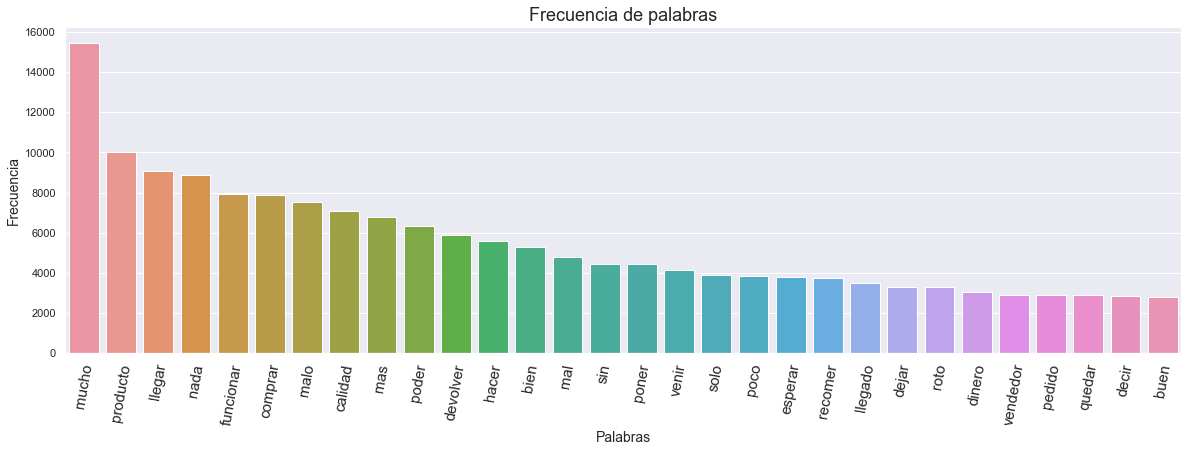

In [30]:
una_tokens=[]
normalizar(una, stopwords, una_tokens)
una_tokens=list(itertools.chain(*una_tokens)) #convierte una lista de listas en una única lista.
frecuencias(una_tokens, N=30)

- **Dos estrellas:**

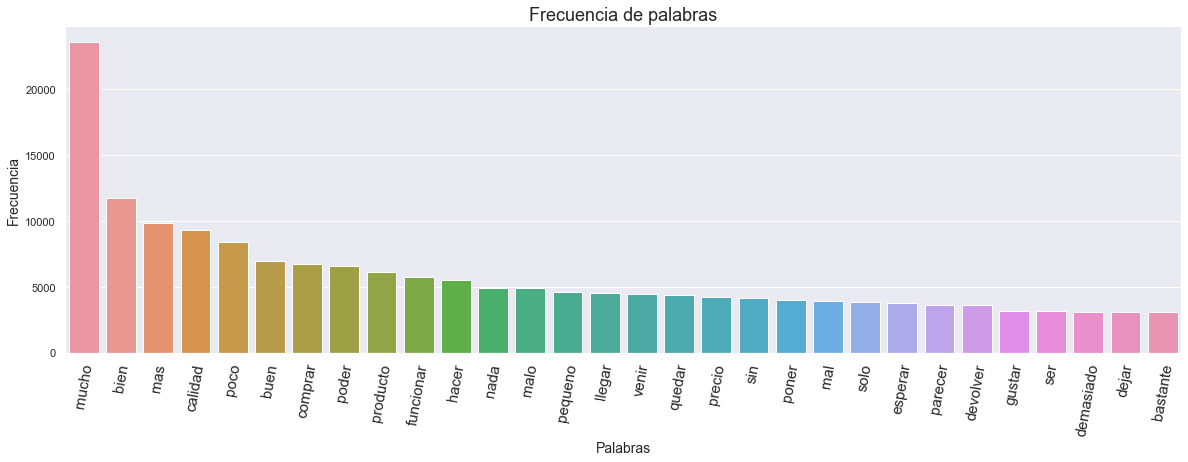

In [31]:
dos_tokens=[]
normalizar(dos, stopwords, dos_tokens)
dos_tokens=list(itertools.chain(*dos_tokens)) #convierte una lista de listas en una única lista.
frecuencias(dos_tokens, N=30)

- **Tres estrellas:**

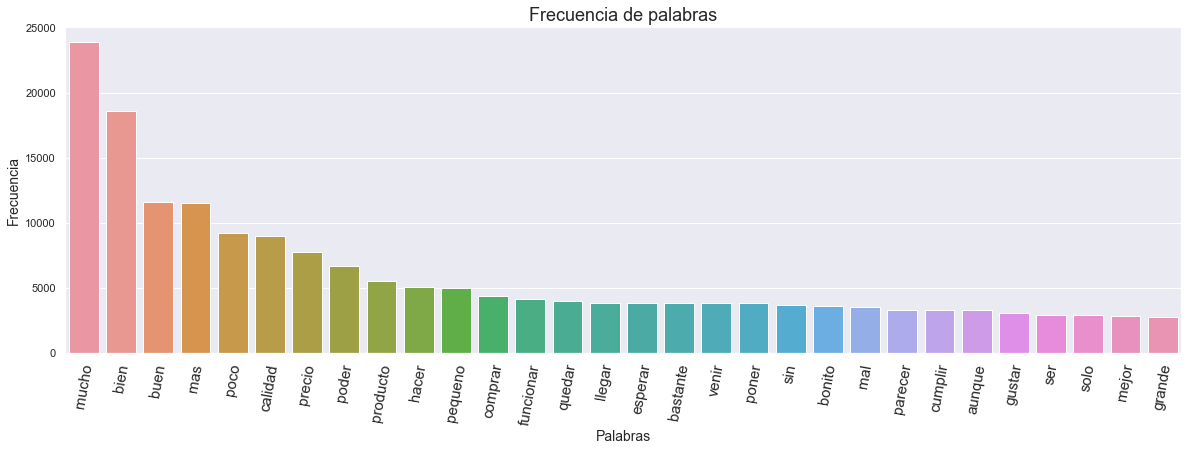

In [32]:
tres_tokens=[]
normalizar(tres, stopwords, tres_tokens)
tres_tokens=list(itertools.chain(*tres_tokens)) #convierte una lista de listas en una única lista.
frecuencias(tres_tokens, N=30)

- **Cuatro estrellas:**

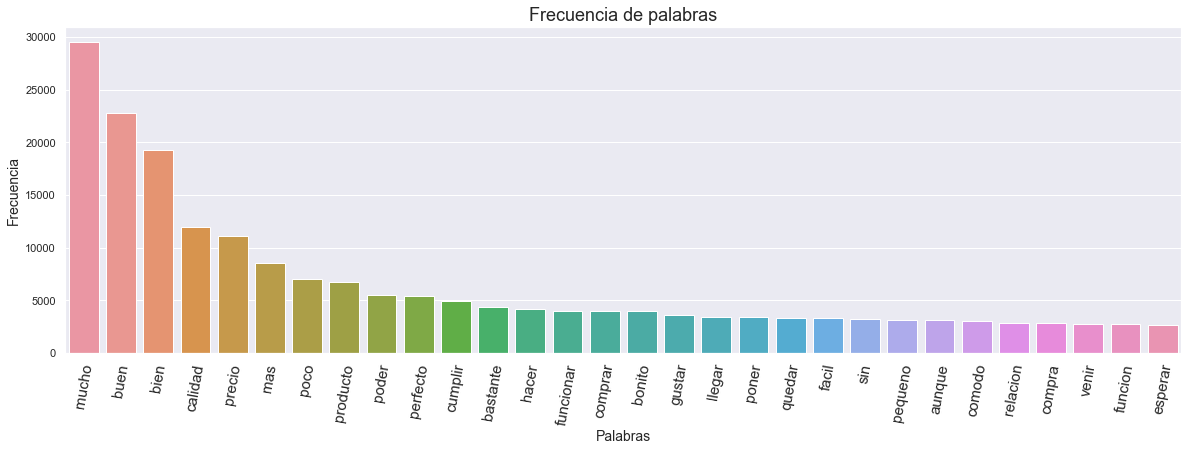

In [33]:
cuatro_tokens=[]
normalizar(cuatro, stopwords, cuatro_tokens)
cuatro_tokens=list(itertools.chain(*cuatro_tokens)) #convierte una lista de listas en una única lista.
frecuencias(cuatro_tokens, N=30)

- **Cinco estrellas:**

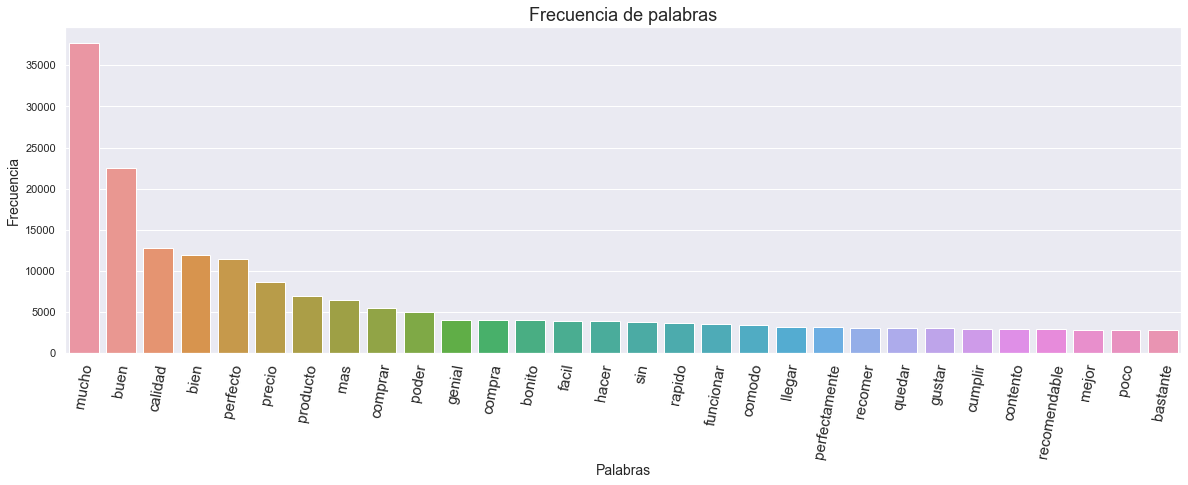

In [34]:
cinco_tokens=[]
normalizar(cinco, stopwords, cinco_tokens)
cinco_tokens=list(itertools.chain(*cinco_tokens)) #convierte una lista de listas en una única lista.
frecuencias(cinco_tokens, N=30)

Observaciones:

* Se observa que las palabras mucho, bien, buen, mas y calidad son las más frecuentes en todas la calificaciones, esto podría traer problemas en los modelos.
* Existen palabras claves en cada categoría que nos pueden ayudar con la clasificación de los comentarios como malo, poco, regular o perfecto, genial, contento. 
* Unir adverbios de cantidad con adjetivos calificativos pueden agregar mayor información al modelo. Como por ejemplo 'mala calidad' o 'muy bonito', entre otros.

# Modelos Machine Learning

Es importante resaltar que estamos trabajando con un problema de clasificación. Además, corresponde a un método de aprendizaje supervisado, donde debemos entrenar un modelo que nos permita predecir la cantidad de estrellas equivalentes a un comentario dado sobre un producto.

Para implementar modelos de Machine Learning hemos trabajado anteriormente en este notebook con el preprocesamiento de los datos. Se normalizó el texto eliminado elementos que pudiesen generar sesgo, se identificaron los tokens del corpus, se llevaron las palabras a su raíz con los procesos de stemming y lemmatización.

En lo que sigue, transformaremos nuestros datos a entidades numéricas para que los modelos de Machine Learning los puedan procesar. Para esto utilizaremos la técnica TFIDF (Term Frecuency & Inverse Data Frecuency) que nos permite convertir una colección de datos en bruto a una matríz de atributos numéricos. Además, nos permite medir no sólo cuánto aparece una palabra en un comentario, sino también qué tan frecuente es esa palabra en todo nuestro corpus y les asigna un peso. 

Utilizaremos la clase `TfidfVectorizer` de la librería Sklearn. La fórmula que usa para calcular la matríz es:

$$ TFIDF = TF * IDF $$

TF = número de veces que una palabra aparece en un comentario / número total de palabras en todo el corpus.

IDF = logaritmo del número de comentarios en el corpus entre el número de comentarios en los que ha aparecido la palabra. 
 
**'Los términos raros son más informativos que los términos frecuentes'**


## Modelos 

Se entrenarán algunos modelos en su versión clasificadora y se medirán sus desempeños. Se tiene en cuenta que la distribución de las clases está balanceada y además, se considerará de ser necesario, ajustar el modelo para la clasificación de múltiples clases. 

Empezaremos con un árbol de decisión con una profundidad baja como modelo benchmark y y luego, trabajaremos con los modelos LinearSVC, Random Forest, Multinomial NB, Regresión Logística y XGBoost. Se escogerán los dos mejores modelos para luego optimizar sus hiperparámetros. 

## Métricas 

Para justificar el desempeño de nuestros modelos se elije como métrica el `accuracy` ya que contamos con un dataset cuyas clases están perfectamente balanceadas. Entonces, calcularemos del total de los comentarios cuántos han sido clasificados en la clase correcta, y esto nos bastará para saber si el modelo está clasificando bien o no. Utilizaremos la clase `accuracy_score` de la librería Sklearn para calcularlo y, para visualizar la clasificación por estrellas utilizaremos la clase `confusion_matrix`. 

In [35]:
def confusion(y_test,y_pred):
    names=['Una','Dos','Tres','Cuatro','Cinco']
    cm=confusion_matrix(y_test,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

### Modelo Benchmark: Árbol de Decisión

Se considera tomar como modelo benchmark un árbol de decisión con sus parámetros definidos por default excepto la profundidad máxima que la definiremos como `max_depth = 10`. Lo primero que haremos será vectorizar nuestros datos usando la clase `TfidfVectorizer`. Usaremos sus parámetros por default menos la cantidad máxima de features que la estableceremos como `max_features = 1000`.

In [36]:
# Vectorización
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(dataset_clean['reviews_lemma']).toarray()
y = dataset_clean.stars
print(X.shape)
print(y.shape)

(210000, 1000)
(210000,)


Generamos los conjuntos de entrenamiento y testeo, con una proporción de los datos del 70% y 30% respectivamente. Se agrega el parámetro `stratify` para asegurar un equilibrio en la distribución de las clases, en este caso la cantidad de estrellas. 

In [37]:
# Train/Test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, stratify=dataset_clean.stars,random_state=42)

In [38]:
#Modelo
tree = DecisionTreeClassifier(max_depth=10, random_state=42)
tree.fit(X_train, y_train)
#Genero predicciones
y_pred = tree.predict(X_test)

0.3807460317460317


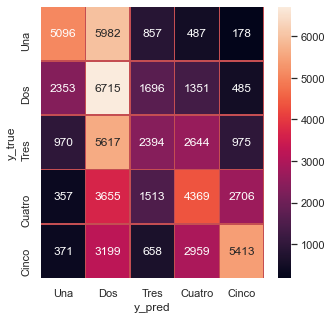

In [41]:
#Evaluo el modelo
print(accuracy_score(y_test, y_pred))
confusion_tree = confusion(y_test,y_pred)
acc_tree
confusion_tree

Observaciones:

* El desempeño del modelo es bastante bajo, 38.07%.
* La efectividad del modelo parece estar afectada por la mala clasificación de las clases correspondientes a 3 y 4 estrellas. 
* En este caso se observa que la clases con mayor cantidad de aciertos son las de 1,2 y 5 estrellas. 
* La clase que peor se clasifica es la de 3 estrellas, lo cual es esperado porque esta calificación suele tener comentarios negativos o positivos sobre los productos.

In [42]:
gc.collect()

19852

### Selección de modelos

Ahora, como comentamos anteriormente, entrenaremos 5 modelos de clasificación con sus parámetros definidos por default exceptuando el parámetro n_estimators del modelo Random Forest, el cual definiremos como `n_estimator = 5`; los parámetro max_iter y multi_class de la regresión logística, los cuales definiremos como `max_iter = 1000` por la cantidad de instancias que tenemos y `multi_class = 'multinomial'` porque estamos en presencia de un problema de múltiples clases. Por último, definiremos en los casos necesarios una semilla determinada; `random_state = 42`. Dependiendo de su desempeño se eligirán los dos mejores para continuar con la optimización de hiperparámetros.

Es importante resaltar que continuamos considerando la cantidad máxima de features igual a 1000, sin embargo, más adelante probaremos variar este parámetro para observar si se pueden obtener mejoras.  

Definimos una función que nos permita observar el desempeño de cada modelo y su clasificación por categoría:

In [43]:
def seleccion_modelo(X_train, X_test, y_train, y_test):
    modelos=[LinearSVC(random_state=42),
            RandomForestClassifier(n_estimators = 5, random_state=42),
            MultinomialNB(),
            LogisticRegression(random_state=42, max_iter=1000, multi_class= 'multinomial'),
            XGBClassifier(random_state=42)]
    nombre_modelo = ['LinearSVC','Random Forest','MultinomialNB','Regresión Logística', 'XGBoost']
    for modelo in modelos:
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        print('Modelo:', nombre_modelo[modelos.index(modelo)])
        print('acc :  ', accuracy_score(y_test, y_pred))
        confusion(y_test,y_pred)

Modelo: LinearSVC
acc :   0.5148730158730159


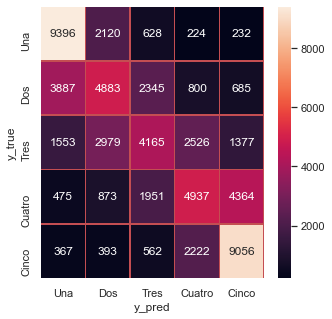

Modelo: Random Forest
acc :   0.4297619047619048


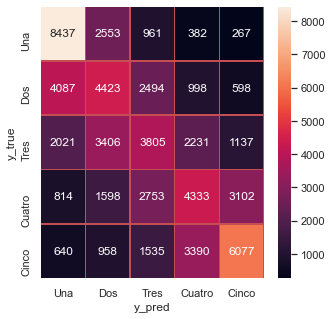

Modelo: MultinomialNB
acc :   0.5005555555555555


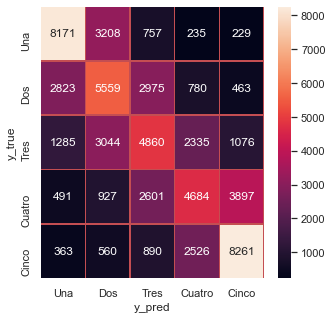

Modelo: Regresión Logística
acc :   0.5223809523809524


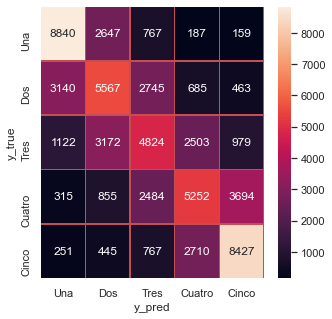

Modelo: XGBoost
acc :   0.5052698412698413


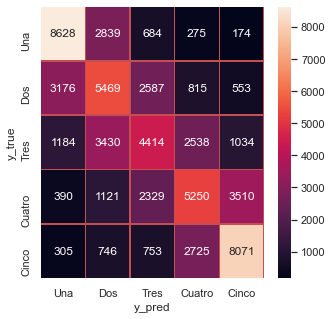

In [44]:
seleccion_modelo(X_train, X_test, y_train, y_test)

Despúes de entrenar los modelos, se observa que los que presentan mayor efectividad en la clasificación son: LinerarSVC y Regresión Logística. Por lo que continuaremos trabajando con estos dos.

Se destaca también que todos los modelos tienden a clasificar mejor las clases extremo; las correspondientes a 1 y 5 estrellas. Esto parece ser natural ya que son los comentarios que suelen tener esta calificación tienen palabras relacionadas con información negativa o positiva sobre el producto. 

## Optimización de hiperparámetros

Lo primero que haremos será variar la cantidad máxima de features a generar por el vectorizador TFIDF. Además, en este punto, consideraremos producir n-gramas que corresponden a la unión de las palabras más correlacionadas en cada categoría. 

* `max_features`: define la cantidad máxima de features que se desean generar, en este caso, variaremos este parametro con los valores [1000, 2000, 4000, 6000, 8000, 10000].
* `ngram_range`: determina la cantidad de n-gramas que deseamos generar. Lo definimos como (1,2) para obtener unigramas y bigramas más correlacionados en el corpus.

Entonces, veamos el desempeño de los modelos variando la cantidad máxima de features e incluyendo bigramas. Definimos una función que nos permita encontrar el valor óptimo de `max_features` para cada modelo:

In [48]:
def tfidf_optimo(max_features, modelo):
    lista_acc_train = []    
    lista_acc_test = [] 

    for i in max_features:    
        #Generamos el vectorizador
        vectorizer = TfidfVectorizer(max_features = i, ngram_range = (1,2))
        #Vectorizamos los datos
        X = vectorizer.fit_transform(dataset_clean['reviews_lemma']).toarray()
        y = dataset_clean.stars
        #Genero los conjuntos train/test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=dataset_clean.stars, random_state=42) 
        #Defino el modelo 
        clf = modelo
        clf.fit(X_train, y_train) 
        #Calculo predicciones
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        acc_train = accuracy_score(y_train, y_pred_train) 
        acc_test = accuracy_score(y_test, y_pred_test)
        # Agregar acc a la lista
        lista_acc_train.append(acc_train)
        lista_acc_test.append(acc_test)

    print('Accuracy Train: ', lista_acc_train)    
    print('Accuracy Test: ', lista_acc_test)        

    #Grafico
    plt.figure(figsize = (10,8))
    plt.plot(max_features,lista_acc_train,'o-',label='train', color = 'red')
    plt.plot(max_features,lista_acc_test,'o-',label='test', color = 'purple')
    plt.ylim(0.45, 0.65)
    plt.legend()
    plt.xlabel('Número de features')
    plt.ylabel('Accuracy')
    plt.show()

Accuracy Train:  [0.5137278911564626, 0.5335986394557823, 0.552843537414966, 0.5848639455782313]
Accuracy Test:  [0.5097619047619047, 0.5209206349206349, 0.5274920634920635, 0.5267301587301587]


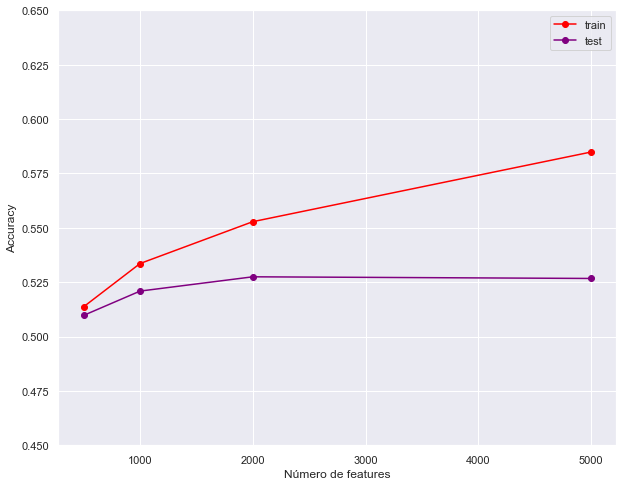

In [49]:
max_features = [500,1000,2000,5000]
svc = LinearSVC(random_state=42)
tfidf_optimo(max_features, svc)

In [50]:
gc.collect()

3044

Accuracy Train:  [0.5225442176870748, 0.541734693877551, 0.5611904761904762, 0.5885578231292518]
Accuracy Test:  [0.5136507936507937, 0.5271269841269841, 0.5346031746031746, 0.5379047619047619]


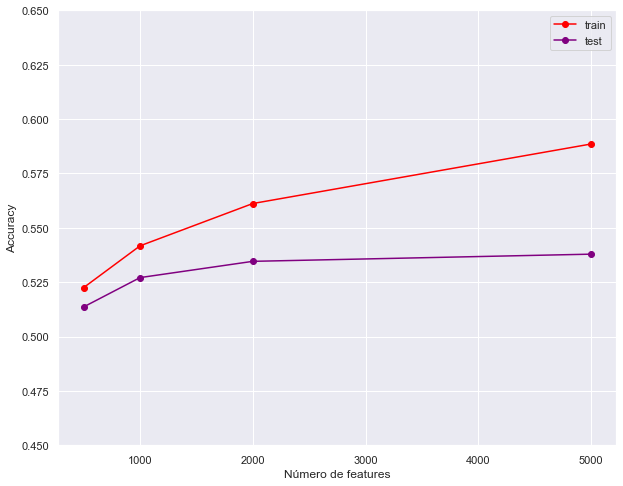

In [51]:
max_features = [500,1000,2000,5000]
lr = LogisticRegression(random_state=42, max_iter=1000, multi_class= 'multinomial')
tfidf_optimo(max_features, lr)

In [52]:
gc.collect()

3116

Observaciones:

* Se ha variado la cantidad máxima de features entre 500 y 5000, con la generación de unigramas y bigramas.
* Se observa el comportamiento del desempeño de los modelos para los conjuntos de train y test, con la intención de escoger el valor máximo features que mantenga un comportamiento similar en ambos conjuntos. 
* Para ambos modelos se observa que el valor óptimo de features generados es 1000.
* Para valores menores a 1000 se observa el peor desempeño de los modelos.
* Para valores mayores a 1000 se observa mejor desempeño para conjunto de train mientras que para el conjunto de test se mantiene constante en ambos modelos.
* La inclusión de unigramas y bigramas mejora la exactitud del problema.

### Unigramas y bigramas generados.

Utilicemos ahora la clase `chi2` del modulo `feature_selection` de Sklearn la cual nos ayudará a encontrar los términos (unigramas y bigramas) más relevantes producidos por el vectorizador utilizado, calculando la correlación entre los features. Para esto, definimos la siguiente función:

In [53]:
def correlacion(N , X, y, vectorizer):
    for star in range(1,6):
        x_tfidf_chi2 = chi2(X, y== star)
        indices = np.argsort(x_tfidf_chi2[0])
        x_tfidf_names = np.array(vectorizer.get_feature_names())[indices]
        unigrams = [v for v in x_tfidf_names if len(v.split(' ')) == 1]
        bigrams = [v for v in x_tfidf_names if len(v.split(' ')) == 2]
        print("Número de estrellas'{}':".format(star))
        print("  . Unigramas más correlacionados:\n       . {}".format('\n       . '.join(unigrams[-N:])))
        print("  . Bigramas más correlacionados:\n       . {}".format('\n       . '.join(bigrams[-N:])))

In [54]:
N=3
vectorizer = TfidfVectorizer(max_features= 1000, ngram_range = (1,2))
X = vectorizer.fit_transform(dataset_clean['reviews_lemma']).toarray()
y = dataset_clean.stars
correlacion(N, X, y, vectorizer)

Número de estrellas'1':
  . Unigramas más correlacionados:
       . dinero
       . nada
       . malo
  . Bigramas más correlacionados:
       . malo calidad
       . mucho malo
       . nunca llegar
Número de estrellas'2':
  . Unigramas más correlacionados:
       . demasiado
       . buen
       . perfecto
  . Bigramas más correlacionados:
       . mucho buen
       . mucho bien
       . calidad precio
Número de estrellas'3':
  . Unigramas más correlacionados:
       . poco
       . perfecto
       . regular
  . Bigramas más correlacionados:
       . mucho buen
       . esperar mas
       . precio bien
Número de estrellas'4':
  . Unigramas más correlacionados:
       . relacion
       . precio
       . buen
  . Bigramas más correlacionados:
       . mucho bien
       . relacion calidad
       . calidad precio
Número de estrellas'5':
  . Unigramas más correlacionados:
       . encantado
       . genial
       . perfecto
  . Bigramas más correlacionados:
       . buen calidad
       .

Observaciones:

* Como veníamos observando, los unigramas y bigramas más correlacionados con las categorías de 1 y 5 estrellas representa de manera explícita la relación entre la cantidad de estrellas asignadas y su comentario.
* Los unigramas y bigramas generados para las estrellas 2,3 y 4 presentan características similares. Siendo ésto uno de los motivos por los cuales es más difícil clasificar los comentarios para estás clases.

## Optimización de Hiperparámetros

Teniendo ya el valor óptimo de la cantidad máxima de features para cada modelo, procedemos en lo que sigue a optimizar los hiperparámetros de cada uno. Para ésto se hará uso de la funcionalidad `GridSearchCV` de Sklearn, la cual nos permite hacer variaciones de los hiperparámetros del modelo y además, incluye la técnica de Validación Cruzada que nos ayudará a obtener independencia de la partición de nuestros datos.

Las variables X y y a utilizar son las generadas en el bloque anterior.

Los hiperparámetros que consideramos variar para ambos modelos son:

`penalty`: el cual está asociado a la norma de penalización usada en el modelo. Podrá ser l1 para considerar regularización de Lasso o l2 para la regularización de Ridge, de esta manera producir el modelo más simple y que mejor generalicen.

`C`: siendo un parámetro que también regulariza el modeo, con la intención de equilibrar la obtención de lograr un error bajo para el conjunto de entrenamiento y minimizar el valor de los pesos asignados. 

Para la regresión logística se considera también:

`max_iter`: representa el número máximo de iteraciones para que el modelo converja a un resultado.

Definimos entonces los conjuntos de train y test:

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=dataset_clean.stars, random_state=42) 

Entrenamos los modelos con sus respectivas grillas de parámetros:

In [56]:
svc = LinearSVC(random_state=42)
# Grilla de parámetros
param_grid = {'penalty': ['l1', 'l2'],
              'C': [1,2,4,6,8,10],
              }
# GridSearch
grid_search = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Mejores parametros: "+str(grid_search.best_params_))
print("Mejor Score: "+str(grid_search.best_score_)+'\n')

Mejores parametros: {'C': 4, 'penalty': 'l2'}
Mejor Score: 0.5162176870748298



In [57]:
lr = LogisticRegression(random_state=42, multi_class = 'multinomial')
# Grilla de parámetros
param_grid = {'penalty': ['l1', 'l2'],
              'max_iter': [1000, 1500],
              'C': [1,2,4,6,8,10]              
              }
# GridSearch
grid_search = GridSearchCV(lr, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Mejores parametros: "+str(grid_search.best_params_))
print("Mejor Score: "+str(grid_search.best_score_)+'\n')

Mejores parametros: {'C': 1, 'max_iter': 1000, 'penalty': 'l2'}
Mejor Score: 0.523578231292517



### Comparación de resultados

Con los parámetros encontrados entrenaremos nuevamente los modelos y compararemos con el modelo benchmark.

0.5209365079365079


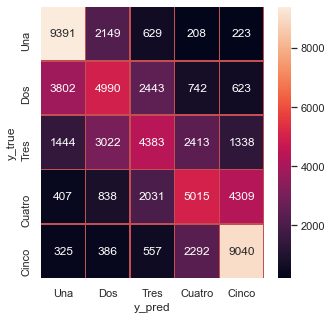

In [58]:
#Modelo LinearSVC
svc = LinearSVC(C= 4, penalty= 'l2', random_state=42)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print(accuracy_score(y_test, y_pred))
confusion(y_test,y_pred)

0.5271269841269841


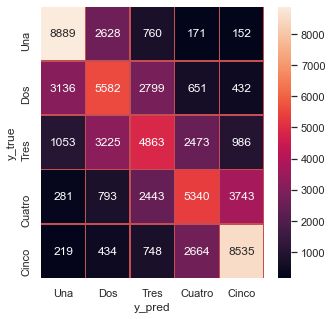

In [59]:
# Modelo Regresión Logística
lr = LogisticRegression(C= 1, max_iter= 1000, multi_class= 'multinomial', penalty= 'l2', random_state=42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(accuracy_score(y_test, y_pred))
confusion(y_test,y_pred)

In [60]:
acc= [0.377, 0.521, 0.527, ]
columnas = ['Accuracy'] 
filas = ['Benchmark', 'LinearSVC', 'Regresión Logística'] 

comparacion = pd.DataFrame(acc, columns=columnas, index=filas)
comparacion.head()

,Accuracy
Benchmark,0.377
LinearSVC,0.521
Regresión Logística,0.527


Se encuentra que el modelo que mejor clasifica es el de regresión logística. Se observa una mejora importante entre el modelo benchmark y los modelos optimizados.

# Conclusiones

Después de un exhaustivo proceso de transformación de datos, evaluación modelos y optimización de hiperparámetros, hemos encontrado dos modelos que presentan un desempeño general de aproximadamente el 50% de efectividad para la clasificación de comentarios sobre un producto vendido en amazon. Si bien, parece ser un performance bajo respecto al deseado, se encontraron una serie de características a destacar:

* El modelo que mejor predice la calificación de un comentario por estrellas es el de la Regresión Logística en su modalidad de múltiples clases.
* Las clases mejor predichas por el modelo son las correspondientes a 1 y 5 estrellas. Esto se debe al uso de palabras definidas como negativas o positivas que utiliza el usuario al escribir el comentario.
* Las clases 2, 3 y 4 son las clases que le cuesta más al modelo predecir. Esto esta relacionado a la subjetividad con la que usuario puede escribir y calificar un producto. Por lo que quizás use palabras positivas y negativas en un comentario de, por ejemplo, 3 estrellas y esto produce una confusión al momento de clasificar. 
* La optimización del método de vectorización agrega valor a los resultados obtenidos por los modelos, en especial la inclusión  de bigramas.
* La optimización de hiperparámetros de los modelos también permite encontrar mejores resultados.

Para probar en futuras iteraciones:

* Utilizar en vez de las palabras lemmatizadas, las generadas a través del proceso de stemming.
* Implementar modelos de Deep Learning para optener mejores resultados. Implementar redes neuronales.
* Utilizar otro tipo de vectorizador, como por ejemplo, Word2Vec.
* Existen muchos y mejores recursos para normalizar texto en inglés. Quizás implementar un buen traductor al corpus y modelarlo en inglés genere mejores resultados.

Ahora, ¿valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Probemos generar un modelo con estas características:

## Modelo Binario

Utilizaremos el dataset cargado, limpio y que además contiene los comentarios y sus títulos unidos.

In [61]:
dataset_lemma.head()

,Unnamed: 0,stars,reviews_lemma
0,0,1,nada buen pantalla menos recibido respuesta fa...
1,1,1,horrible comprar saber ingle informatico despu...
2,2,1,obligar comprar unidad llegar solo forma recla...
3,3,1,entrar descalificar vendedor solo poder decir ...
4,4,1,llegar tarde talla equivocado devolver


Ordenemos el dataset de forma ascendente según el número de estrellas, esto será útil para separar el dataset en dos categorías.

In [62]:
dataset_lemma = dataset_lemma.sort_values('stars')

Asigno al dataset  una nueva etiqueta con dos categorías, una positiva que estará compuesta por los comentarios calificados con 3,4, y 5 estrellas. Y otra categoría negativa que contendrá los comentarios calificados con 1 y 2 estrellas.

In [63]:
def set_values(row, value):
    return value[row]
   
map_dictionary ={1 : "Neg", 2 :"Neg", 3 : "Pos", 4 :"Pos", 5:"Pos"} 
   
dataset_lemma['etiqueta'] = dataset_lemma['stars'].apply(set_values, args =(map_dictionary, )) 
dataset_lemma.drop(['Unnamed: 0'], axis=1, inplace=True)
dataset_lemma.reset_index(drop=True, inplace=True)
dataset_lemma.head()

,stars,reviews_lemma,etiqueta
0,1,nada buen pantalla menos recibido respuesta fa...,Neg
1,1,bateria fallar duro nada carga poder ser desga...,Neg
2,1,borrado dibujo vaso estafa compra comprear,Neg
3,1,gran cosa apariencia mucho bien luego tinto ju...,Neg
4,1,comprar funda samsung funda bien movil borde r...,Neg


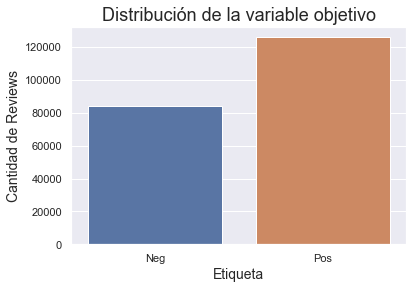

In [64]:
#Cómo están distribuidas las etiquetas generadas
sns.countplot(data=dataset_lemma, x=dataset_lemma.etiqueta)
plt.title('Distribución de la variable objetivo', fontsize=18)
plt.xlabel('Etiqueta', fontsize=14)
plt.ylabel('Cantidad de Reviews', fontsize=14)
plt.show()

In [65]:
print(pd.value_counts(dataset_lemma['etiqueta'], sort = True))

Pos    126000
Neg     84000
Name: etiqueta, dtype: int64


En este punto, nos encontramos con un pequeño problema y es que las nuevas clases generadas presentan una distribución desbalanceada, es decir, tenemos más comentarios positivos que negativos y esto podría afectar al modelo en su proceso de clasificación. Entonces, para solucionar ésto y porque nos lo permite el modelo de Regresión Logística, ajustaremos el parámetro `class_weigth` igual a 'balanced' el cual asignará un peso a cada clase y nos permitirá tener una muestra equilibrada. 

Primero, entrenaremos un modelo con las clases desbalanceadas y después con el parámetro ajustado para observar las diferencias en los desempeños de los modelos. 

In [66]:
# Vectorizamos
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(dataset_lemma['reviews_lemma']).toarray()
y = dataset_lemma.etiqueta

In [67]:
# Generamos el conjunto de train y test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, stratify=dataset_lemma.etiqueta,random_state=42)

0.8242063492063492


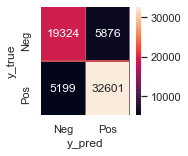

In [68]:
# Entrenamos y evaluamos el modelo
lr = LogisticRegression(max_iter= 1000, multi_class= 'multinomial', random_state=42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(accuracy_score(y_test, y_pred))
names=['Neg','Pos']
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(2,2))
sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

Se observa que, en comparación al modelo con las 5 clases de calificación mejora notablemente la efectividad del modelo de un 0.527 a un 0.824. Sin embargo, las clases en este punto están desbalanceadas. Ahora, vamos a optimizar la cantidad de features generados por el vectorizador tfidf:

Accuracy Train:  [0.8210612244897959, 0.8320068027210884, 0.8414829931972789, 0.8529455782312925]
Accuracy Test:  [0.8182539682539682, 0.8283015873015873, 0.8342222222222222, 0.8382380952380952]


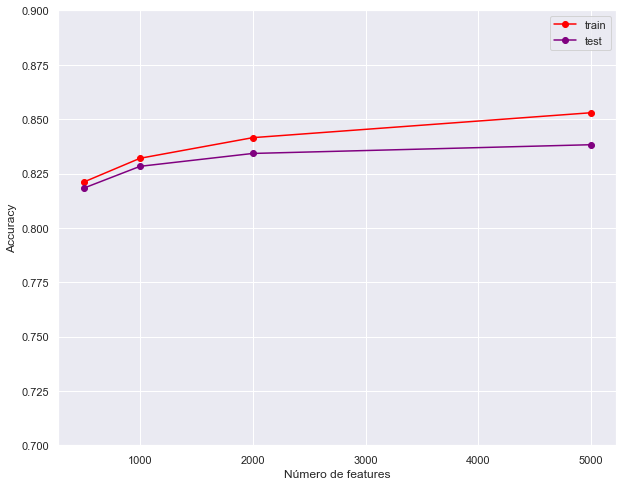

In [69]:
max_features = [500,1000,2000,5000]
lista_acc_train = []    
lista_acc_test = [] 

for i in max_features:    
    #Generamos el vectorizador
    vectorizer = TfidfVectorizer(max_features = i, ngram_range = (1,2))
    #Vectorizamos los datos
    X = vectorizer.fit_transform(dataset_lemma['reviews_lemma']).toarray()
    y = dataset_lemma.etiqueta
    #Genero los conjuntos train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=dataset_lemma.etiqueta, random_state=42) 
    #Defino el modelo 
    lr = LogisticRegression(random_state=42, max_iter=1000, multi_class= 'multinomial')
    lr.fit(X_train, y_train) 
    #Calculo predicciones
    y_pred_train = lr.predict(X_train)
    y_pred_test = lr.predict(X_test)
    acc_train = accuracy_score(y_train, y_pred_train) 
    acc_test = accuracy_score(y_test, y_pred_test)
    # Agregar acc a la lista
    lista_acc_train.append(acc_train)
    lista_acc_test.append(acc_test)

print('Accuracy Train: ', lista_acc_train)    
print('Accuracy Test: ', lista_acc_test)        

#Grafico
plt.figure(figsize = (10,8))
plt.plot(max_features,lista_acc_train,'o-',label='train', color = 'red')
plt.plot(max_features,lista_acc_test,'o-',label='test', color = 'purple')
plt.ylim(0.7, 0.9)
plt.legend()
plt.xlabel('Número de features')
plt.ylabel('Accuracy')
plt.show()

Se ha encontrado que con la inclusión de bigramas y un `max_features = 1000` encontramos una precisión buena y similar para los conjuntos de train y test. En lo que sigue vamos a optimizar los hiperparámetros del modelo, incluyendo el balanceo de las clases. 

In [70]:
vectorizer = TfidfVectorizer(max_features = 1000, ngram_range = (1,2))
X = vectorizer.fit_transform(dataset_lemma['reviews_lemma']).toarray()
y = dataset_lemma.etiqueta

X_train, X_test, y_train, y_test = train_test_split(X ,y ,test_size = 0.3, stratify = dataset_lemma.etiqueta, random_state = 42)

lr = LogisticRegression(random_state=42, multi_class = 'multinomial')
# Grilla de parámetros
param_grid = {'penalty': ['l1', 'l2'],
              'max_iter': [1000, 1500],
              'C': [1,2,4,6,8,10],
              'class_weight': ['balanced']
              }
# GridSearch
grid_search = GridSearchCV(lr, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Mejores parametros: "+str(grid_search.best_params_))
print("Mejor Score: "+str(grid_search.best_score_)+'\n')

Mejores parametros: {'C': 4, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2'}
Mejor Score: 0.8231904761904761



In [71]:
gc.collect()

18865

0.824


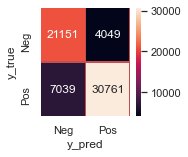

In [72]:
lr = LogisticRegression(C= 4, max_iter= 1000, multi_class= 'multinomial', penalty= 'l2', random_state=42, class_weight = 'balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(accuracy_score(y_test, y_pred))
names=['Neg','Pos']
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(2,2))
sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

Observaciones:

* Se obtiene un mejor performance del modelo considerando sólo dos etiquetas, una positiva y una negativa. Pasando de un 0.527 a 0.824 de precisión.

* Considerar ajustar el parámetro class_weigth en la Regresión Logística no nos arrojó mejoras en el desempeño general del modelo, sin embargo, logró clasificar mejor los comentarios negativos.

* Sería utíl considerar el problema binario para respaldar la toma de decisiones en cuanto a si un producto en líneas generales es bueno o malo. Y con esto considerar si continua o no en el mercado.  
    